In [ ]:
!pip install pytorch-pretrained-bert
!pip install transformers

In [ ]:
import os
import re
import csv
import itertools
import json

import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from collections import defaultdict, OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from nltk import FreqDist

In [ ]:
import pytorch_pretrained_bert

In [ ]:
# Get GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# tell Pytorch to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Import BioBERT

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

In [ ]:
!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  vocab.txt
config.json				model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin


In [ ]:
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

In [ ]:
!ls biobert_v1.1_pubmed/
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!ls biobert_v1.1_pubmed/

In [ ]:
!ls 

biobert_v1.1_pubmed  biobert_weights  gdrive  sample_data


# Data

In [ ]:
from google.colab import drive
drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
MAX_LEN=128
BATCH_SIZE=16
num_folds=2
tokenizer = BertTokenizer(vocab_file='biobert_v1.1_pubmed/vocab.txt', do_lower_case=False)

In [ ]:
def tags_list_computer(candidates_list,raw_text_list,thematic_feature):
  """Finds anf labels thematic features from their JSON data annotations
     using a cascade of Regex rules
  """

  del_features=[]

  for candidate in candidates_list:
    feature_text=[]
    feature_type=re.findall(re.compile('type=\"(.*?)\"'),candidate)[0]
    length=int(re.findall(re.compile('length=\"(.*?)\"'),candidate)[0])
    index=int(re.findall(re.compile('index=(.*?) '),candidate)[0])
    candidate_no=int(re.findall(re.compile('id=\"c(.*?)\"'),candidate)[0])
    
    if feature_type == thematic_feature:
      for i in range(index,index+length):
        del_features.append(raw_text_list[i])  
  return [feat for feat in raw_text_list if feat not in del_features]

In [ ]:
def candidates_selector(data,thematic_feature):
  """Finds all candidate thematic features by tag from news article
     also prepares a raw untagged corpus after deleting excluded thematic feature if any
  """

  raw_text_list=re.findall(re.compile('<token id=\"t\d+\"> (.*?) </token>'),data['tagged_content'])
  candidates_list=re.findall(re.compile('<candidate (.*?)></candidate> '),data['tagged_content'])  
  re_raw_list=tags_list_computer(candidates_list,raw_text_list,thematic_feature)
  raw_doc = ' '.join([str(elem) for elem in re_raw_list])  
  return raw_doc

In [ ]:
corpora = '/content/gdrive/MyDrive/Colab Data/articles'
tagged_data=[]
irrelevant_docs=0
irrelevant_docs_address=[]
df_corpus={'Content':[],'Label':[]}
del_thematic_feature='none' #thematic feature to be ignored either date, disease, location or host

for subdir, dirs, files in os.walk(corpora):
  """Walks through the directory containing PADI-Web JSON News datasets
     and cleans the corpus selecting relevant and irrelevant documents 
  """
  for file in files:
    path = os.path.join(subdir, file)
    
    with open(path,'r') as f:
      data=json.load(f)
      if data['candidateLabels']: #not an empty list thus relevant document
        if data['content']:
          content=candidates_selector(data,del_thematic_feature)
          df_corpus['Content'].append(content.replace('\r', '').replace('\t', '').replace('\n','').replace('<br /> ',''))
          df_corpus['Label'].append('relevant')

      else:#irrelevant document
        if data['content']:
          content=candidates_selector(data,del_thematic_feature)
          df_corpus['Content'].append(content.replace('\r', '').replace('\t', '').replace('\n','').replace('<br /> ',''))
          df_corpus['Label'].append('irrelevant')

In [ ]:
data=pd.DataFrame(df_corpus)

In [ ]:
data.head()

,Content,Label
0,Instead of creating unnecessary fear and paran...,irrelevant
1,The International Monetary Fund has given Bots...,irrelevant
2,10 October 2015 Last updated at : 5:05 AM Mala...,irrelevant
3,YAMAGUCHI -- An outbreak of highly pathogenic ...,relevant
4,SEOUL South Korea has confirmed a fresh case o...,relevant


In [ ]:
label_encoder=LabelEncoder()
label_encoder.fit(data['Label'])

LabelEncoder()

In [ ]:
X=list(data['Content'])
y=list(label_encoder.transform(data['Label']))

In [ ]:
label_encoder.inverse_transform([0])

array(['irrelevant'], dtype=object)

In [ ]:
X[0:3]

["Instead of creating unnecessary fear and paranoia over rabies , the authorities should promote proper education on the disease so Malaysians can better protect themselves and their pets . COMMENT By Carol N With the recent announcement of a rabies outbreak in Malaysia , there exists many misconceptions about the disease and how preventable and treatable it is . Allow me to dispel some of these myths with referenced sources . Myth 1 : Anyone who gets bitten by a rabid dog can not be saved and will soon die a terribly painful death It is true that rabies will result in a painful death through inflammation of the central nervous system . Rabies in humans is untreatable upon the onset of clinical symptoms such as a tingling sensation , fear and anxiety which progresses to hyperactivity and paralysis . The key point here , as stated in this WHO fact sheet , is that the incubation period between contact with rabies and onset of symptoms is typically 1 to 3 months . Only very rarely do symp

In [ ]:
y[0:3]

[0, 0, 0]

In [ ]:
def tok_with_labels(doc, label):
  
  tok_doc=tokenizer.tokenize(doc)
  
  return tok_doc, [label]

tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(X, y)]

In [ ]:
#tok_texts_and_labels[0]

In [ ]:
tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
labels = np.array([tok_label_pair[1] for tok_label_pair in tok_texts_and_labels])

In [ ]:
print(tok_texts[0])

['Instead', 'of', 'creating', 'unnecessary', 'fear', 'and', 'para', '##no', '##ia', 'over', 'r', '##abi', '##es', ',', 'the', 'authorities', 'should', 'promote', 'proper', 'education', 'on', 'the', 'disease', 'so', 'Malaysian', '##s', 'can', 'better', 'protect', 'themselves', 'and', 'their', 'pets', '.', 'CO', '##MM', '##EN', '##T', 'By', 'Carol', 'N', 'With', 'the', 'recent', 'announcement', 'of', 'a', 'r', '##abi', '##es', 'outbreak', 'in', 'Malaysia', ',', 'there', 'exists', 'many', 'mi', '##sco', '##nce', '##ption', '##s', 'about', 'the', 'disease', 'and', 'how', 'prevent', '##able', 'and', 'treat', '##able', 'it', 'is', '.', 'All', '##ow', 'me', 'to', 'di', '##sp', '##el', 'some', 'of', 'these', 'myths', 'with', 'referenced', 'sources', '.', 'My', '##th', '1', ':', 'Anyone', 'who', 'gets', 'bitten', 'by', 'a', 'r', '##abi', '##d', 'dog', 'can', 'not', 'be', 'saved', 'and', 'will', 'soon', 'die', 'a', 'terribly', 'painful', 'death', 'It', 'is', 'true', 'that', 'r', '##abi', '##es',

In [ ]:
len(tok_texts[50])

861

In [ ]:
print(labels[0])

[0]


In [ ]:
len(tok_texts)

503

In [ ]:
len(labels)

503

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
input_ids.shape

(503, 200)

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
len(attention_masks)

503

# Model

In [ ]:
config = BertConfig.from_json_file('biobert_v1.1_pubmed/config.json')
tmp_d = torch.load('biobert_v1.1_pubmed/pytorch_model.bin', map_location=device)
state_dict = OrderedDict()

for i in list(tmp_d.keys())[:199]:
    x = i
    if i.find('bert') > -1:
        x = '.'.join(i.split('.')[1:])
    state_dict[x] = tmp_d[i]

In [ ]:
#vocab_len=len(np.unique(labels))+1
vocab_len=2

In [ ]:
class EpidBioBert(nn.Module):

  def __init__(self, vocab_len, config, state_dict):
    super().__init__()
    self.bert = BertModel(config)
    self.bert.load_state_dict(state_dict, strict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.batchnorm=nn.BatchNorm1d(1,affine=False)
    self.output = nn.Linear(self.bert.config.hidden_size, vocab_len)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    encoded_layer, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    encl = encoded_layer[-1]
    max_pooled, _  = torch.max(encl, 1)
    norm=torch.squeeze(self.batchnorm(torch.unsqueeze(max_pooled,1)),0)
    dropped = self.dropout(norm)
    out = self.output(dropped)
    return out, out.argmax(-1)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0.
    batch_no = 1
    for step,batch in enumerate(data_loader):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        outputs,y_hat = model(b_input_ids,b_input_mask)
        _,preds = torch.max(outputs,dim=2)

        outputs = outputs.view(-1,outputs.shape[-1])
        b_labels_shaped = b_labels.view(-1)

        loss=loss_fn(outputs,b_labels_shaped)
        correct_predictions += torch.sum(preds == b_labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        batch_no=batch_no+1

    return correct_predictions.double()/len(data_loader.dataset) , np.mean(losses)

In [ ]:
def model_eval(model,data_loader,loss_fn,device):
    model = model.eval()
    
    losses = []
    correct_predictions = 0.

    original_labels, new_labels = [], []
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
        
            outputs,y_hat = model(b_input_ids,b_input_mask)
        
            _,preds = torch.max(outputs,dim=2)

            outputs = outputs.view(-1,outputs.shape[-1])
            b_labels_shaped = b_labels.view(-1)
            loss = loss_fn(outputs,b_labels_shaped)
            correct_predictions += torch.sum(preds == b_labels)
            losses.append(loss.item())

            label_indices = y_hat.to('cpu').numpy()
            pred_indices = b_labels_shaped.to('cpu').numpy()

            for label_idx,pred_idx in zip(label_indices,pred_indices):
              new_labels.append(label_idx[0])
              original_labels.append(pred_idx)

        print('\nPrecision_Score: ',precision_score(original_labels,new_labels,pos_label=1))
        print('\nRecall_Score: ',recall_score(original_labels,new_labels,pos_label=1))
        print('\nF_Score: ',f1_score(original_labels,new_labels,pos_label=1))
    return correct_predictions/len(data_loader.dataset) , np.mean(losses)

In [ ]:
#our_cv_acc, our_cv_f_score = [],[]
#for num_folds in range(2,5):
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
split_size=.2
acc_per_fold, f_score_per_fold = [],[]
for train, test in kfold.split(input_ids, labels):
  
  #input_ids=input_ids[train]
  #labels=labels[train]

  #test_input_ids=input_ids[test]
  #test_labels=labels[test]

  tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids[train], labels[train],
                                                            random_state=2018, test_size=split_size)
  tr_masks, val_masks, _, _ = train_test_split(np.array(attention_masks)[train], input_ids[train],
                                              random_state=2018, test_size=split_size)

  n_attention_masks = [[float(i != 0.0) for i in ii] for ii in tr_inputs]

  tr_masks, test_masks, _, _ = train_test_split(n_attention_masks, tr_inputs,
                                              random_state=2018, test_size=split_size)

  tr_inputs, test_inputs, tr_tags, test_tags = train_test_split(tr_inputs, tr_tags,
                                                              random_state=2018, test_size=split_size)

  tr_inputs = torch.tensor(tr_inputs)
  val_inputs = torch.tensor(val_inputs)
  test_inputs = torch.tensor(test_inputs)


  tr_tags = torch.tensor(tr_tags)
  val_tags = torch.tensor(val_tags)
  test_tags = torch.tensor(test_tags)

  tr_masks = torch.tensor(tr_masks)
  val_masks = torch.tensor(val_masks)
  test_masks = torch.tensor(test_masks)

  train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE, drop_last=True)

  valid_data = TensorDataset(val_inputs, val_masks, val_tags)
  valid_sampler = SequentialSampler(valid_data)
  valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE, drop_last=True)

  test_data = TensorDataset(test_inputs, test_masks, test_tags)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE, drop_last=True)

  model = EpidBioBERT(vocab_len,config,state_dict)
  model.to(device)

  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
          {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.01},
          {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.0}
      ]

  optimizer = AdamW(
      optimizer_grouped_parameters,
      lr=1e-5,
      eps=1e-8
  )
  epochs = 5 #Simply train for 1 epoch
  max_grad_norm = 1.0

  total_steps = len(train_dataloader.dataset) * epochs
  warmup_steps = int(epochs * len(train_dataloader.dataset) * 0.1 / BATCH_SIZE) #mine


  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      #num_warmup_steps=warmup_steps,
      num_training_steps=total_steps
  )
  loss_fn = nn.CrossEntropyLoss().to(device)

  %%time
  history = defaultdict(list)
  best_accuracy = 0
  normalizer = BATCH_SIZE*MAX_LEN
  loss_values = []

  for epoch in range(epochs):
      
      total_loss = 0
      print(f'======== Epoch {epoch+1}/{epochs} ========')
      train_acc,train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,device,scheduler)
      #train_acc = train_acc/normalizer
      print(f'Train Loss: {train_loss} Train Accuracy: {train_acc}')
      total_loss += train_loss.item()
      
      avg_train_loss = total_loss / len(train_dataloader.dataset)  
      loss_values.append(avg_train_loss)
      
      val_acc,val_loss,_ = model_eval(model,valid_dataloader,loss_fn,device)
      #val_acc = val_acc/normalizer
      print(f'Val Loss: {val_loss} Val Accuracy: {val_acc}')
      
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)

  

  """sns.set(style='darkgrid')

  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # learning curve
  plt.plot(loss_values, 'b-o')
  plt.plot(history['train_loss'],'g--',label='Train Loss')
  plt.plot(history['val_loss'],'b',label='Val Loss')

  plt.title("Training loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.show()"""

  test_acc,test_loss,f_score = model_eval(model,test_dataloader,loss_fn,device)
  #test_acc = test_acc
  print(f'Test Loss for fold {fold_no}: {test_loss} Test Accuracy: {test_acc} F Score: {f_score}')
  acc_per_fold.append(test_acc)
  f_score_per_fold.append(f_score)

  fold_no = fold_no + 1

  #our_cv_acc.append(torch.mean(torch.stack(acc_per_fold)))
  #our_cv_f_score.append(np.mean(f_score_per_fold))


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
======== Epoch 1/5 ========
Train Loss: 0.7755016028881073 Train Accuracy: 0.5875


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Precision_Score:  0.0

Recall_Score:  0.0

F_Score:  0.0
Val Loss: 0.6270269751548767 Val Accuracy: 0.6274510025978088
======== Epoch 2/5 ========
Train Loss: 0.5591334044933319 Train Accuracy: 0.7312500000000001

Precision_Score:  0.7142857142857143

Recall_Score:  0.625

F_Score:  0.6666666666666666
Val Loss: 0.5134502351284027 Val Accuracy: 0.7450980544090271
======== Epoch 3/5 ========
Train Loss: 0.4260137140750885 Train Accuracy: 0.8

Precision_Score:  0.8333333333333334

Recall_Score:  0.625

F_Score:  0.7142857142857143
Val Loss: 0.40579689542452496 Val Accuracy: 0.7843137383460999
======== Epoch 4/5 ========
Train Loss: 0.27534659057855604 Train Accuracy: 0.925

Precision_Score:  0.6666666666666666

Recall_Score:  0.875

F_Score:  0.7567567567567567
Val Loss: 0.3570333520571391 Val Accuracy: 0.7647058963775635
======== Epoch 5/5 ========
Train Loss: 0.20934491902589797 Train Accuracy: 0.93125

Precision_Score:  0.6666666666666666

Recall_Score:  0.875

F_Score:  0.75675675675

In [ ]:
#for i in range(0,num_folds):
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {torch.mean(torch.stack(acc_per_fold),dim=0)} (+- {torch.std(torch.stack(acc_per_fold),dim=0)})')
print(f'> F_Score: {np.mean(f_score_per_fold)} (+- {np.std(f_score_per_fold)})')

------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.667073130607605 (+- 0.04656556621193886)
> F_Score: 0.8083333333333333 (+- 0.05833333333333329)


In [ ]:
our_cv_acc=[0.8083,0.8685,0.8680,0.8239,0.8167,0.8784,0.8784,0.8784,0.8784]
svm_glove_cv_acc=[0.1808,0.2620, 0.2007, 0.1452, 0.1713, 0.1873, 0.1759, 0.1859, 0.1731]
svm_ohe_cv_acc=[0.2258, 0.2545, 0.2809, 0.2375, 0.2792, 0.2411, 0.3013, 0.2999, 0.2441]
svm_tfidf_cv_acc=[0.1676, 0.2374, 0.2377, 0.2251, 0.2553, 0.2651, 0.2569, 0.2438, 0.2220]

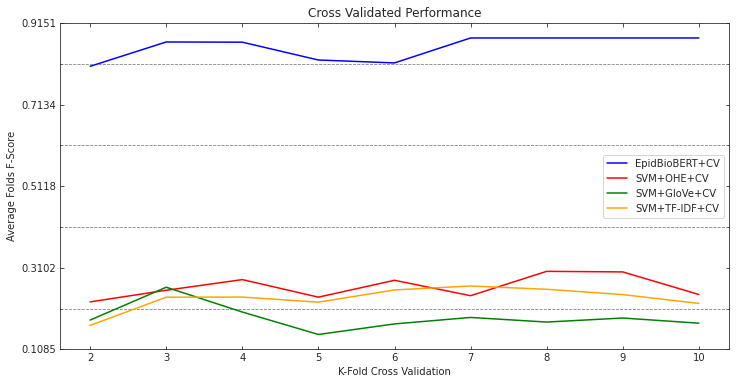

In [ ]:
"""sns.set(style='darkgrid')
sns.set_style("white")
sns.despine(left=True, bottom=True)

sns.set(font_scale=1.5)"""
sns.set_style('ticks',{'xtick.direction': 'out'})
plt.rcParams["figure.figsize"] = (12,6)
cv_range=[2,3,4,5,6,7,8,9,10]

# learning curve
plt.plot(cv_range,our_cv_acc,'b',label='EpidBioBERT+CV')
plt.plot(cv_range,svm_ohe_cv_acc,'r',label='SVM+OHE+CV')
plt.plot(cv_range,svm_glove_cv_acc,'g',label='SVM+GloVe+CV')
plt.plot(cv_range,svm_tfidf_cv_acc,'orange',label='SVM+TF-IDF+CV')


plt.title("Cross Validated Performance")
plt.xlabel("K-Fold Cross Validation")
plt.ylabel("Average Folds F-Score")
plt.legend()

plt.show()